<a href="https://colab.research.google.com/github/runtorain/GenerativeDeepLearning/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/SuperAI_Season4/kaggle.json ~/.kaggle/     # EDIT HERE: Change your path to your kaggle_json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:10<00:00, 160MB/s]
100% 1.33G/1.33G [00:10<00:00, 136MB/s]


In [4]:
# prompt: unzip /content/celeba-dataset.zip -q

!unzip -q /content/celeba-dataset.zip


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (self.img_size[0] // 16, self.img_size[1] // 16)

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * (img_size[0] // 16) * (img_size[1] // 16)
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)

In [23]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad


class Trainer():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):
        """ """
        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.item())


        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.item())

    def _generator_train_iteration(self, data):
        """ """
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate loss and optimize
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.item())

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().item())

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data[0])
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data[0])

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))

    def train(self, data_loader, epochs, save_training_gif=True):
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)

            if save_training_gif:
                # Generate batch of images and convert to grid
                img_grid = make_grid(self.G(fixed_latents).cpu().data)
                # Convert to numpy and transpose axes to fit imageio convention
                # i.e. (width, height, channels)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                # Add image grid to training progress
                training_progress_images.append(img_grid)

        if save_training_gif:
            imageio.mimsave('./training_{}_epochs.gif'.format(epochs),
                            training_progress_images)

    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [8]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define paths
# dataset_path = '/content/img_align_celeba/img_align_celeba'
# train_path = '/content/dataset/train'
# val_path = '/content/dataset/val'
# test_path = '/content/dataset/test'

# # Create directories
# os.makedirs(train_path, exist_ok=True)
# os.makedirs(val_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)

# # Get all image filenames
# all_images = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# # Split dataset
# train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)
# val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# # Function to copy images
# def copy_images(image_list, src_path, dest_path):
#     for img in image_list:
#         shutil.copy(os.path.join(src_path, img), os.path.join(dest_path, img))

# # Copy images
# copy_images(train_images, dataset_path, train_path)
# copy_images(val_images, dataset_path, val_path)
# copy_images(test_images, dataset_path, test_path)

# print("Dataset successfully split into Train, Validation, and Test sets!")


In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = '/content/img_align_celeba/img_align_celeba'
train_path = '/content/dataset/train/face'
val_path = '/content/dataset/val/face'

# Create directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Get all image filenames
all_images = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# Split dataset (80% train, 20% validation)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Function to copy images
def copy_images(image_list, src_path, dest_path):
    for img in image_list:
        shutil.copy(os.path.join(src_path, img), os.path.join(dest_path, img))

# Copy images
copy_images(train_images, dataset_path, train_path)
copy_images(val_images, dataset_path, val_path)

print("Dataset successfully split into Train and Validation sets!")


Dataset successfully split into Train and Validation sets!


In [42]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/img_align_celeba', transform=transform)
# val_dataset = datasets.ImageFolder(root='/content/dataset/train', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [43]:
img_size = (128, 128, 3)

In [44]:
generator = Generator(img_size=img_size, latent_dim=100, dim=16)
discriminator = Discriminator(img_size=img_size, dim=16)

print(generator)
print(discriminator)

Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)
Discriminator(
  (image_to_features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=

In [45]:
import torch
import torch.optim as optim
# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [46]:
epochs = 3
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
trainer.train(train_loader, epochs, save_training_gif=True)


Epoch 1
Iteration 1
D: 9.966782569885254
GP: 9.967277526855469
Gradient norm: 0.001637479872442782
Iteration 51
D: 8.8278226852417
GP: 9.706768035888672
Gradient norm: 0.014855142682790756
G: -0.044698335230350494
Iteration 101
D: 7.647655963897705
GP: 8.187366485595703
Gradient norm: 0.0958576649427414
G: -0.23610073328018188
Iteration 151
D: 5.747105121612549
GP: 5.943271636962891
Gradient norm: 0.2387988567352295
G: -0.2944073975086212

Epoch 2
Iteration 1
D: 4.992652416229248
GP: 5.177363395690918
Gradient norm: 0.3001306354999542
G: -0.2970965504646301
Iteration 51
D: 4.549694538116455
GP: 4.684124946594238
Gradient norm: 0.3418937623500824
G: -0.3639370799064636
Iteration 101
D: 3.670159101486206
GP: 3.789663314819336
Gradient norm: 0.42603057622909546
G: -0.41598427295684814
Iteration 151
D: 3.3338265419006348
GP: 3.4418983459472656
Gradient norm: 0.4716916084289551
G: -0.5136702060699463

Epoch 3
Iteration 1
D: 3.2266435623168945
GP: 3.2765183448791504
Gradient norm: 0.4857023

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [31]:
# Save models
name = 'models'
torch.save(trainer.G.state_dict(), './gen_' + name + '.pt')
torch.save(trainer.D.state_dict(), './dis_' + name + '.pt')

Step 1: Load the Trained Generator

In [47]:
# Assuming `generator` is your trained model
# Load the model if you saved it
# generator = Generator(img_size=img_size, latent_dim=100, dim=16)
# generator.load_state_dict(torch.load('generator.pth'))
generator.eval()  # Set to evaluation mode


Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)

Step 2: Sample Latent Vectors

In [48]:
num_samples = 16  # Number of images to generate
latent_vectors = generator.sample_latent(num_samples)

# If you trained the model on GPU, move the latent vectors to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_vectors = latent_vectors.to(device)
generator.to(device)


Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)

Step 3: Generate Images


In [49]:
with torch.no_grad():  # No need to compute gradients for generation
    generated_images = generator(latent_vectors)


Step 4: Visualize the Generated Images

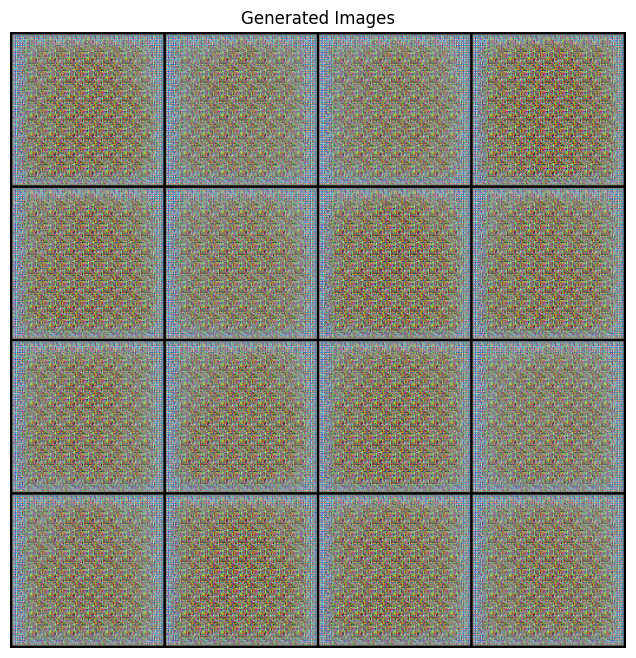

In [50]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Create a grid of images
grid = vutils.make_grid(generated_images, nrow=4, normalize=True)

# Convert to numpy and plot
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert from CHW to HWC for plotting
plt.show()


Step 5: Save Generated Images (Optional)

In [36]:
import torchvision.utils as vutils

# Save the grid of images
vutils.save_image(generated_images, 'generated_images.png', normalize=True, nrow=4)
